***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [4]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)



#### Dropping constants

col_no_unique=[]
for col in df_html.columns[:-1]:
    if len(df_html[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_html.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### 95% same values

lst=[]
for col in df_html.columns[:-1]:
    lst.append([col,dict(df_html[col].value_counts()),df_html[col].value_counts().values[0]>=len(df_html)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_html.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### Dropping columns based on high VIF values

rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_html.shape)

Shape of HTML dataset: (43491, 1461)
0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1464)
1297 columns have more than 95% same values
Shape of our dataset after dropping them: (43491, 167)
38 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43491, 129)


### JavaScript read data

In [5]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_js.columns[:-1]:
    if len(df_js[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_js.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)

#### 95% same values

lst=[]
for col in df_js.columns[:-1]:
    lst.append([col,dict(df_js[col].value_counts()),df_js[col].value_counts().values[0]>=len(df_js)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst


print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_js.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)


#### Dropping columns based on high VIF values

rem=['js_function_.defineProperty(','js_function_.keys(','js_function_.substr','js_function_unescape(','js_function_.log(']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_js.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_js.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 288)
234 columns have more than 95% same values
Shape of our dataset after dropping them: (43294, 54)
5 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43294, 49)


In [6]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [7]:
df_sel=df.copy(deep=True)

In [8]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(random_state=0)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90.63%
Thresh=0.000, n=176, Accuracy: 90

In [11]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

embeded_rf_feature.append('Target')
embeded_rf_feature

['dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.setTimeout(',
 'js_function_.find(',
 'js_function_.get(',
 'js_function_.indexOf(',
 'js_function_.push(',
 'js_function_.replace(',
 'a_href_.com',
 'a_href_https',
 'center_count',
 'form_action_http',
 'iframe_src_https',
 'link_href_.css',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_src_out_of_domain',
 'strong_count',
 'total_count',
 'total_href',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [12]:
fin_col=embeded_rf_feature
df_sel=df_sel[fin_col]

In [13]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

In [14]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [15]:
test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [16]:
train.shape

(32567, 27)

In [17]:
columns=fin_col
columns.remove('Target')

In [18]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9141155157060828
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25542  2296    27838
True         501  4228     4729
__all__    26043  6524    32567

Accuracy of the model for test data is: 0.9075165806927045
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6339   601     6940
True         152  1050     1202
__all__     6491  1651     8142



Logistic Regression
Accuracy of the model for training data is: 0.8890594773850831
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25131  2707    27838
True         906  3823     4729
__all__    26037  6530    32567

Accuracy of the model for test data is: 0.8915499877180054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6273   667     6940
True         216   986     1202
__all__     6489  1653     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9259987103509688
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25615  2223    27838
True         187  4542     4729
__all__    25802  6765    32567

Accuracy of the model for test data is: 0.9118152788012773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6360   580     6940
True         138  1064     1202
__all__     6498  1644     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9030613811527006
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25524  2314    27838
True         843  3886     4729
__all__    26367  6200    32567

Accuracy of the model for test data is: 0.9019896831245394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6352   588     6940
True         210   992     1202
__all__     6562  1580     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9105843338348635
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25605  2233    27838
True         679  4050     4729
__all__    26284  6283    32567

Accuracy of the model for test data is: 0.9078850405305822
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6371   569     6940
True         181  1021     1202
__all__     6552  1590     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9279024779684957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25619  2219    27838
True         129  4600     4729
__all__    25748  6819    32567

Accuracy of the model for test data is: 0.9110783591255219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6355   585     6940
True         139  1063     1202
__all__     6494  1648     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9257837688457641
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25613  2225    27838
True         192  4537     4729
__all__    25805  6762    32567

Accuracy of the model for test data is: 0.9109555391795627
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6354   586     6940
True         139  1063     1202
__all__     6493  1649     8142



Neural Network-1
The accuracy of the model on training data is: 0.9069917401141654


Predicted  False  True  __all__
Actual                         
False      25145  2693    27838
True         336  4393     4729
__all__    25481  7086    32567

The accuracy of the model on test data is: 0.9006386637189879


Predicted  False  True  __all__
Actual                         
False       6256   684     6940
True         125  1077     1202
__all__     6381  1761     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [19]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [20]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.914116,4228.0,25542.0,2296.0,501.0,0.082477,0.105942
LogisticRegression,0.889059,3823.0,25131.0,2707.0,906.0,0.097241,0.191584
RandomForestClassifier,0.925999,4542.0,25615.0,2223.0,187.0,0.079855,0.039543
AdaBoostClassifier,0.903061,3886.0,25524.0,2314.0,843.0,0.083124,0.178262
GradientBoostingClassifier,0.910584,4050.0,25605.0,2233.0,679.0,0.080214,0.143582
ExtraTreeClassifier,0.927902,4600.0,25619.0,2219.0,129.0,0.079711,0.027278
BaggingClassifier,0.925784,4537.0,25613.0,2225.0,192.0,0.079927,0.040601
Neural Network-1,0.906992,4393.0,25145.0,2693.0,336.0,0.096738,0.071051


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.907517,1050.0,6339.0,601.0,152.0,0.086599,0.126456,0.893472,0.694299
LogisticRegression,0.891550,986.0,6273.0,667.0,216.0,0.096110,0.179700,0.862095,0.638644
RandomForestClassifier,0.911815,1064.0,6360.0,580.0,138.0,0.083573,0.114809,0.900809,0.708367
AdaBoostClassifier,0.901990,992.0,6352.0,588.0,210.0,0.084726,0.174709,0.870282,0.664276
GradientBoostingClassifier,0.907885,1021.0,6371.0,569.0,181.0,0.081988,0.150582,0.883715,0.686728
ExtraTreeClassifier,0.911078,1063.0,6355.0,585.0,139.0,0.084294,0.115641,0.900033,0.706355
BaggingClassifier,0.910956,1063.0,6354.0,586.0,139.0,0.084438,0.115641,0.899961,0.706068
Neural Network-1,0.900639,1077.0,6256.0,684.0,125.0,0.098559,0.103993,0.898724,0.687084


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [21]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [22]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [23]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.6027372656081615
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27068   770    27838
True       21348  6490    27838
__all__    48416  7260    55676

Accuracy of the model for test data is: 0.841930729550479
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6646   294     6940
True         993   209     1202
__all__     7639   503     8142



Logistic Regression
Accuracy of the model for training data is: 0.8881564767583878
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22580   5258    27838
True         969  26869    27838
__all__    23549  32127    55676

Accuracy of the model for test data is: 0.8335789732252518
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5642  1298     6940
True          57  1145     1202
__all__     5699  2443     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9526366836698039
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25477   2361    27838
True         276  27562    27838
__all__    25753  29923    55676

Accuracy of the model for test data is: 0.9099729796118889
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6314   626     6940
True         107  1095     1202
__all__     6421  1721     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9082010201882319
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24028   3810    27838
True        1301  26537    27838
__all__    25329  30347    55676

Accuracy of the model for test data is: 0.8760746745271432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6012   928     6940
True          81  1121     1202
__all__     6093  2049     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9253717939507149
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24663   3175    27838
True         980  26858    27838
__all__    25643  30033    55676

Accuracy of the model for test data is: 0.893515106853353
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6169   771     6940
True          96  1106     1202
__all__     6265  1877     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9532832818449601
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25485   2353    27838
True         248  27590    27838
__all__    25733  29943    55676

Accuracy of the model for test data is: 0.9087447801522968
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6312   628     6940
True         115  1087     1202
__all__     6427  1715     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9523852288239097
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25474   2364    27838
True         287  27551    27838
__all__    25761  29915    55676

Accuracy of the model for test data is: 0.9069024809629084
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6288   652     6940
True         106  1096     1202
__all__     6394  1748     8142



Neural Network-1
The accuracy of the model on training data is: 0.9352683382512543


Predicted  False   True  __all__
Actual                          
False      24495   3343    27838
True         261  27577    27838
__all__    24756  30920    55676

The accuracy of the model on test data is: 0.8824613117170228


Predicted  False  True  __all__
Actual                         
False       6059   881     6940
True          76  1126     1202
__all__     6135  2007     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [24]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [25]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.602737,6490.0,27068.0,770.0,21348.0,0.027660,0.766865
LogisticRegression,0.888156,26869.0,22580.0,5258.0,969.0,0.188879,0.034809
RandomForestClassifier,0.952637,27562.0,25477.0,2361.0,276.0,0.084812,0.009915
AdaBoostClassifier,0.908201,26537.0,24028.0,3810.0,1301.0,0.136863,0.046735
GradientBoostingClassifier,0.925372,26858.0,24663.0,3175.0,980.0,0.114053,0.035204
ExtraTreeClassifier,0.953283,27590.0,25485.0,2353.0,248.0,0.084525,0.008909
BaggingClassifier,0.952385,27551.0,25474.0,2364.0,287.0,0.084920,0.010310
Neural Network-1,0.935268,27577.0,24495.0,3343.0,261.0,0.120088,0.009376


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.841931,209.0,6646.0,294.0,993.0,0.042363,0.826123,0.565757,0.193776
LogisticRegression,0.833579,1145.0,5642.0,1298.0,57.0,0.187032,0.047421,0.882774,0.592574
RandomForestClassifier,0.909973,1095.0,6314.0,626.0,107.0,0.090202,0.089018,0.910390,0.713127
AdaBoostClassifier,0.876075,1121.0,6012.0,928.0,81.0,0.133718,0.067388,0.899447,0.653033
GradientBoostingClassifier,0.893515,1106.0,6169.0,771.0,96.0,0.111095,0.079867,0.904519,0.681410
ExtraTreeClassifier,0.908745,1087.0,6312.0,628.0,115.0,0.090490,0.095674,0.906918,0.707999
BaggingClassifier,0.906902,1096.0,6288.0,652.0,106.0,0.093948,0.088186,0.908933,0.706573
Neural Network-1,0.882461,1126.0,6059.0,881.0,76.0,0.126945,0.063228,0.904913,0.666566


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [26]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [27]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

1    4729
0    4729
Name: Target, dtype: int64

In [28]:
X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

In [29]:
print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (9458, 26)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5759145696764644
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4575   154     4729
True        3857   872     4729
__all__     8432  1026     9458

Accuracy of the model for test data is: 0.8424220093343159
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6664   276     6940
True        1007   195     1202
__all__     7671   471     8142



Logistic Regression
Accuracy of the model for training data is: 0.881898921547896
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3794   935     4729
True         182  4547     4729
__all__     3976  5482     9458

Accuracy of the model for test data is: 0.8271923360353721
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5591  1349     6940
True          58  1144     1202
__all__     5649  2493     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9482977373651935
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4329   400     4729
True          89  4640     4729
__all__     4418  5040     9458

Accuracy of the model for test data is: 0.8989191844755589
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6213   727     6940
True          96  1106     1202
__all__     6309  1833     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8954324381475999
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4000   729     4729
True         260  4469     4729
__all__     4260  5198     9458

Accuracy of the model for test data is: 0.8635470400393024
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5896  1044     6940
True          67  1135     1202
__all__     5963  2179     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.911820680905054
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4121   608     4729
True         226  4503     4729
__all__     4347  5111     9458

Accuracy of the model for test data is: 0.8784082535003684
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6029   911     6940
True          79  1123     1202
__all__     6108  2034     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9519983083104251
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4307   422     4729
True          32  4697     4729
__all__     4339  5119     9458

Accuracy of the model for test data is: 0.8927781871775976
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6164   776     6940
True          97  1105     1202
__all__     6261  1881     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9475576231761472
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4330   399     4729
True          97  4632     4729
__all__     4427  5031     9458

Accuracy of the model for test data is: 0.8917956276099238
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6153   787     6940
True          94  1108     1202
__all__     6247  1895     8142



Neural Network-1
The accuracy of the model on training data is: 0.917635863768573


Predicted  False  True  __all__
Actual                         
False       3982   747     4729
True          32  4697     4729
__all__     4014  5444     9458

The accuracy of the model on test data is: 0.8436502087939082


Predicted  False  True  __all__
Actual                         
False       5708  1232     6940
True          41  1161     1202
__all__     5749  2393     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [30]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [31]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.575915,872.0,4575.0,154.0,3857.0,0.032565,0.815606
LogisticRegression,0.881899,4547.0,3794.0,935.0,182.0,0.197716,0.038486
RandomForestClassifier,0.948298,4640.0,4329.0,400.0,89.0,0.084584,0.018820
AdaBoostClassifier,0.895432,4469.0,4000.0,729.0,260.0,0.154155,0.054980
GradientBoostingClassifier,0.911821,4503.0,4121.0,608.0,226.0,0.128568,0.047790
ExtraTreeClassifier,0.951998,4697.0,4307.0,422.0,32.0,0.089237,0.006767
BaggingClassifier,0.947558,4632.0,4330.0,399.0,97.0,0.084373,0.020512
Neural Network-1,0.917636,4697.0,3982.0,747.0,32.0,0.157962,0.006767


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.842422,195.0,6664.0,276.0,1007.0,0.039769,0.837770,0.561230,0.186076
LogisticRegression,0.827192,1144.0,5591.0,1349.0,58.0,0.194380,0.048253,0.878683,0.582896
RandomForestClassifier,0.898919,1106.0,6213.0,727.0,96.0,0.104755,0.079867,0.907689,0.692516
AdaBoostClassifier,0.863547,1135.0,5896.0,1044.0,67.0,0.150432,0.055740,0.896914,0.636058
GradientBoostingClassifier,0.878408,1123.0,6029.0,911.0,79.0,0.131268,0.065724,0.901504,0.658002
ExtraTreeClassifier,0.892778,1105.0,6164.0,776.0,97.0,0.111816,0.080699,0.903743,0.679596
BaggingClassifier,0.891796,1108.0,6153.0,787.0,94.0,0.113401,0.078203,0.904198,0.678603
Neural Network-1,0.843650,1161.0,5708.0,1232.0,41.0,0.177522,0.034110,0.894184,0.613895


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [33]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 1326 features
EntitySet scattered to workers in 4.623 seconds
Elapsed: 00:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [34]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [35]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [36]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [37]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [38]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

X.shape

The train/test split ratio is 70:30


(40709, 40)

In [39]:
feature_name

['total_count',
 'strong_count + total_count',
 'script_src_out_of_domain + total_count',
 'script_async_true + total_count',
 'script_async_true + script_src_out_of_domain',
 'p_count + total_count',
 'meta_count + total_count',
 'link_type_text/css + total_count',
 'link_type_application/rsd+xml + total_count',
 'link_rel_shortlink + total_count',
 'link_href_out_of_domain + total_count',
 'link_href_http + total_count',
 'link_href_.css + total_count',
 'js_function_.replace( + total_count',
 'js_function_.push( + total_count',
 'js_function_.indexOf( + total_count',
 'js_function_.get( + total_count',
 'js_function_.find( + total_count',
 'iframe_src_https + total_count',
 'form_action_http + total_count',
 'dom_function_window.addEventListener( + total_count',
 'dom_function_document.write( + total_count',
 'center_count + total_count',
 'a_href_.com + total_count',
 'total_href / total_count',
 'total_count / link_href_out_of_domain',
 'total_count + total_href',
 'script_src_out

In [40]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [41]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8726625111308994
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27697   141    27838
True        4006   723     4729
__all__    31703   864    32567

Accuracy of the model for test data is: 0.8650208793908131
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6895    45     6940
True        1054   148     1202
__all__     7949   193     8142



Logistic Regression
Accuracy of the model for training data is: 0.8759787514969141
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24700  3138    27838
True         901  3828     4729
__all__    25601  6966    32567

Accuracy of the model for test data is: 0.8774256939326947
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6156   784     6940
True         214   988     1202
__all__     6370  1772     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9255074154819296
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25614  2224    27838
True         202  4527     4729
__all__    25816  6751    32567

Accuracy of the model for test data is: 0.9109555391795627
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6360   580     6940
True         145  1057     1202
__all__     6505  1637     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8988239629072374
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25555  2283    27838
True        1012  3717     4729
__all__    26567  6000    32567

Accuracy of the model for test data is: 0.897322525178089
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6366   574     6940
True         262   940     1202
__all__     6628  1514     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9103386864003439
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25620  2218    27838
True         702  4027     4729
__all__    26322  6245    32567

Accuracy of the model for test data is: 0.9082535003684599
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6384   556     6940
True         191  1011     1202
__all__     6575  1567     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9279024779684957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25619  2219    27838
True         129  4600     4729
__all__    25748  6819    32567

Accuracy of the model for test data is: 0.9110783591255219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6358   582     6940
True         142  1060     1202
__all__     6500  1642     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9255074154819296
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25614  2224    27838
True         202  4527     4729
__all__    25816  6751    32567

Accuracy of the model for test data is: 0.9103414394497666
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6354   586     6940
True         144  1058     1202
__all__     6498  1644     8142



Neural Network-1


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

The accuracy of the model on training data is: 0.8860502963286898


Predicted  False  True  __all__
Actual                         
False      24709  3129    27838
True         582  4147     4729
__all__    25291  7276    32567

The accuracy of the model on test data is: 0.8840579710144928


Predicted  False  True  __all__
Actual                         
False       6149   791     6940
True         153  1049     1202
__all__     6302  1840     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [42]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [43]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.872663,723.0,27697.0,141.0,4006.0,0.005065,0.847114
LogisticRegression,0.875979,3828.0,24700.0,3138.0,901.0,0.112724,0.190527
RandomForestClassifier,0.925507,4527.0,25614.0,2224.0,202.0,0.079891,0.042715
AdaBoostClassifier,0.898824,3717.0,25555.0,2283.0,1012.0,0.082010,0.213999
GradientBoostingClassifier,0.910339,4027.0,25620.0,2218.0,702.0,0.079675,0.148446
ExtraTreeClassifier,0.927902,4600.0,25619.0,2219.0,129.0,0.079711,0.027278
BaggingClassifier,0.925507,4527.0,25614.0,2224.0,202.0,0.079891,0.042715
Neural Network-1,0.886050,4147.0,24709.0,3129.0,582.0,0.112400,0.123070


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.865021,148.0,6895.0,45.0,1054.0,0.006484,0.876872,0.558322,0.271994
LogisticRegression,0.877426,988.0,6156.0,784.0,214.0,0.112968,0.178037,0.854498,0.609500
RandomForestClassifier,0.910956,1057.0,6360.0,580.0,145.0,0.083573,0.120632,0.897897,0.704344
AdaBoostClassifier,0.897323,940.0,6366.0,574.0,262.0,0.082709,0.217970,0.849661,0.637609
GradientBoostingClassifier,0.908254,1011.0,6384.0,556.0,191.0,0.080115,0.158902,0.880491,0.684738
ExtraTreeClassifier,0.911078,1060.0,6358.0,582.0,142.0,0.083862,0.118136,0.899001,0.705493
BaggingClassifier,0.910341,1058.0,6354.0,586.0,144.0,0.084438,0.119800,0.897881,0.703192
Neural Network-1,0.884058,1049.0,6149.0,791.0,153.0,0.113977,0.127288,0.879368,0.643538


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [44]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

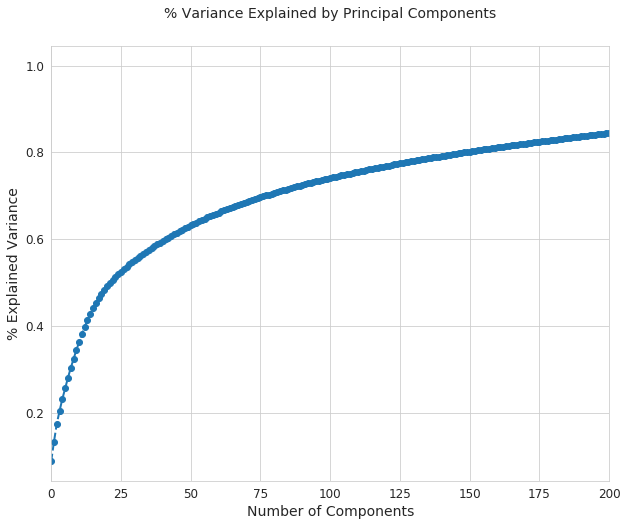

In [45]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [47]:
pca=PCA(n_components=150,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 150 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 150 components is: 0.7991138273693339


In [48]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [49]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,150).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9142690453526576
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25548  2290    27838
True         502  4227     4729
__all__    26050  6517    32567

Accuracy of the model for test data is: 0.9070253009088676
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6340   600     6940
True         157  1045     1202
__all__     6497  1645     8142



Logistic Regression
Accuracy of the model for training data is: 0.9014953787576381
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25342  2496    27838
True         712  4017     4729
__all__    26054  6513    32567

Accuracy of the model for test data is: 0.9012527634487841
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6311   629     6940
True         175  1027     1202
__all__     6486  1656     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9257223569871342
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25615  2223    27838
True         196  4533     4729
__all__    25811  6756    32567

Accuracy of the model for test data is: 0.9114468189633996
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6368   572     6940
True         149  1053     1202
__all__     6517  1625     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9072066816102189
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25482  2356    27838
True         666  4063     4729
__all__    26148  6419    32567

Accuracy of the model for test data is: 0.9059199213952346
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6357   583     6940
True         183  1019     1202
__all__     6540  1602     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9132250437559493
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25624  2214    27838
True         612  4117     4729
__all__    26236  6331    32567

Accuracy of the model for test data is: 0.9086219602063376
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6375   565     6940
True         179  1023     1202
__all__     6554  1588     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9279024779684957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25619  2219    27838
True         129  4600     4729
__all__    25748  6819    32567

Accuracy of the model for test data is: 0.9113239990174404
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6361   579     6940
True         143  1059     1202
__all__     6504  1638     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9257223569871342
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25614  2224    27838
True         195  4534     4729
__all__    25809  6758    32567

Accuracy of the model for test data is: 0.9108327192336035
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6356   584     6940
True         142  1060     1202
__all__     6498  1644     8142



Neural Network-1
The accuracy of the model on training data is: 0.9221604691884302


Predicted  False  True  __all__
Actual                         
False      25489  2349    27838
True         186  4543     4729
__all__    25675  6892    32567

The accuracy of the model on test data is: 0.9042004421518055


Predicted  False  True  __all__
Actual                         
False       6291   649     6940
True         131  1071     1202
__all__     6422  1720     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [50]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [51]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.914269,4227.0,25548.0,2290.0,502.0,0.082262,0.106154
LogisticRegression,0.901495,4017.0,25342.0,2496.0,712.0,0.089662,0.150560
RandomForestClassifier,0.925722,4533.0,25615.0,2223.0,196.0,0.079855,0.041446
AdaBoostClassifier,0.907207,4063.0,25482.0,2356.0,666.0,0.084633,0.140833
GradientBoostingClassifier,0.913225,4117.0,25624.0,2214.0,612.0,0.079532,0.129414
ExtraTreeClassifier,0.927902,4600.0,25619.0,2219.0,129.0,0.079711,0.027278
BaggingClassifier,0.925722,4534.0,25614.0,2224.0,195.0,0.079891,0.041235
Neural Network-1,0.922160,4543.0,25489.0,2349.0,186.0,0.084381,0.039332


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.907025,1045.0,6340.0,600.0,157.0,0.086455,0.130616,0.891465,0.691696
LogisticRegression,0.901253,1027.0,6311.0,629.0,175.0,0.090634,0.145591,0.881888,0.673099
RandomForestClassifier,0.911447,1053.0,6368.0,572.0,149.0,0.082421,0.123960,0.896810,0.704358
AdaBoostClassifier,0.905920,1019.0,6357.0,583.0,183.0,0.084006,0.152246,0.881874,0.681494
GradientBoostingClassifier,0.908622,1023.0,6375.0,565.0,179.0,0.081412,0.148918,0.884835,0.689061
ExtraTreeClassifier,0.911324,1059.0,6361.0,579.0,143.0,0.083429,0.118968,0.898801,0.705783
BaggingClassifier,0.910833,1060.0,6356.0,584.0,142.0,0.084150,0.118136,0.898857,0.704917
Neural Network-1,0.904200,1071.0,6291.0,649.0,131.0,0.093516,0.108985,0.898750,0.693047


In [52]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')